In [1]:
%load_ext autoreload
%autoreload 2

import pprint
from typing import OrderedDict

import numpy as np
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchvision.datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm

import models.resnet
import models.resnet_dropout
import models.unet_model
import utils.detection_metrics
import utils.metrics
import utils.model
import utils.visualisations
from utils.temperature_scaling import ModelWithTemperature

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]

VOC_DICT = {cls: i for i, cls in enumerate(VOC_CLASSES)}


class VOCTransform(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, label):
        annotation = label["annotation"]
        id = int(annotation["filename"].replace(".jpg", "").replace("_", ""))
        out = {
            "boxes": [],
            "labels": [],
            "image_id": torch.tensor(id, dtype=torch.int64),
            "area": [],
            "iscrowd": []
        }
        for obj in annotation["object"]:
            box_dict = obj["bndbox"]
            box = [float(box_dict["xmin"]), float(box_dict["ymin"]),
                   float(box_dict["xmax"]), float(box_dict["ymax"])]
            out["boxes"].append(box)
            out["labels"].append(VOC_DICT[obj["name"]])
            out["area"].append((box[2]-box[0]) * (box[3] - box[1]))
            out["iscrowd"].append(0)
        out["boxes"] = torch.as_tensor(out["boxes"], dtype=torch.float)
        out["labels"] = torch.as_tensor(out["labels"], dtype=torch.int64)
        out["area"] = torch.as_tensor(out["area"], dtype=torch.float)
        out["iscrowd"] = torch.as_tensor(out["iscrowd"], dtype=torch.uint8)
        return out


def collate_fn(batch):
    return list(zip(*batch))


transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip()
])


target_transforms = torchvision.transforms.Compose([
    VOCTransform()
])


data_train = torchvision.datasets.VOCDetection(
    root="VOC", download=True, image_set="train", transform=transforms_train, target_transform=VOCTransform())
data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=16,
                                                shuffle=True,
                                                collate_fn=collate_fn)


data_test = torchvision.datasets.VOCDetection(
    root="VOC", download=True, image_set="val", transform=torchvision.transforms.ToTensor(), target_transform=VOCTransform())
data_loader_test = torch.utils.data.DataLoader(data_test,
                                               batch_size=16,
                                               shuffle=False,
                                               collate_fn=collate_fn)

Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC
Using downloaded and verified file: VOC/VOCtrainval_11-May-2012.tar
Extracting VOC/VOCtrainval_11-May-2012.tar to VOC


In [62]:
# model = models.unet_model.UNet(3, 21).to(device)
model = torch.load("checkpoints/faster_rcnn_box_predictor_dropout0.5.pt")

In [63]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Seque

In [6]:
def bbox_dict_to_tensor(pred: dict):
    if "scores" not in pred:
        pred["scores"] = torch.ones_like(pred["labels"])
    return torch.cat((pred["labels"].unsqueeze(1), pred["scores"].unsqueeze(
        1), pred["boxes"]), 1).tolist()


def validate_model(model, data_loader, device):
    model.eval()
    all_pred_boxes = []
    all_true_boxes = []
    train_idx = 0
    progress_bar = tqdm(data_loader)
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()}
                    for t in targets]

        with torch.no_grad():
            out = model(images)
        for idx, pred in enumerate(out):
            bboxes = bbox_dict_to_tensor(pred)
            true_bboxes = bbox_dict_to_tensor(targets[idx])
            nms_boxes = utils.detection_metrics.nms(
                bboxes,
                iou_threshold=0.5,
                threshold=0.5,
                box_format="corners",
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes:
                # many will get converted to 0 pred
                # if box[1] > threshold:
                all_true_boxes.append([train_idx] + box)
            train_idx += 1

    AP_50 = utils.detection_metrics.mean_average_precision(
        all_pred_boxes, all_true_boxes, iou_threshold=0.5, box_format="corners", num_classes=21)
    AP_75 = utils.detection_metrics.mean_average_precision(
        all_pred_boxes, all_true_boxes, iou_threshold=0.75, box_format="corners", num_classes=21)
    print(f'AP 50: {AP_50:.2f} AP 75: {AP_75:.2f}')
    return all_pred_boxes, all_true_boxes


pred_boxes, true_boxes = validate_model(
    model,  data_loader_test, device)

  0%|          | 0/364 [00:00<?, ?it/s]/home/jirka/miniconda3/envs/confidence/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 364/364 [03:09<00:00,  1.92it/s]


AP 50: 0.64 AP 75: 0.41


In [182]:
import matplotlib.patches as patches

def plot_image(image, boxes, gt_boxes):
    """Plots predicted bounding boxes on the image"""
    if isinstance(image, torch.Tensor):
        image = torch.permute(image, (1,2,0))
    im = np.array(image)

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(15,15))
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        cls = box[1]
        confidence = box[2]
        box = box[3:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

        # upper_left_x = box[0] - box[2] / 2
        # upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=5*confidence,
            edgecolor="r",
            facecolor="none"
        )
        plt.text(box[0], box[1], VOC_CLASSES[int(cls)], c="r")
        # Add the patch to the Axes
        ax.add_patch(rect)

    for box in gt_boxes:
        cls = box[1]
        box = box[3:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

        # upper_left_x = box[0] - box[2] / 2
        # upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=1,
            edgecolor="g",
            facecolor="none"

        )
        plt.text(box[0], box[1], VOC_CLASSES[int(cls)], c="g")

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [214]:
def correct_boxes(preds, gt, num_classes, iou_threshold=0.5):
    max_idx = gt[-1][0]
    TP = torch.zeros((max_idx + 1, num_classes))
    FP = torch.zeros_like(TP)
    FN = torch.zeros_like(TP)
    for img_idx in range(max_idx + 1):
        pred_boxes = sorted(list(filter(lambda box: box[0]==img_idx, preds)), key=lambda box: box[2], reverse=True)
        true_boxes = list(filter(lambda box: box[0]==img_idx, gt))
        for i,true_box in enumerate(true_boxes[:]):
            for j,pred_box in enumerate(pred_boxes[:]):
                if(true_box[1] == pred_box[1] and 
                utils.detection_metrics.intersection_over_union(
                    torch.tensor(pred_box[3:]), 
                    torch.tensor(true_box[3:]), 
                    box_format="corners") > iou_threshold):
                    TP[img_idx][int(true_box[1])] += 1
                
                    true_boxes.pop(i)
                    pred_boxes.pop(j)
        for box in pred_boxes:
            FP[img_idx][int(box[1])] += 1
        for box in true_boxes:
            FN[img_idx][int(box[1])] += 1
    return TP, FP, FN


def correct_boxes(preds, gt, num_classes, iou_threshold=0.5):
    max_idx = gt[-1][0]
    TP = []
    FP = []
    FN = []
    for img_idx in range(max_idx + 1):
        pred_boxes = sorted(list(filter(lambda box: box[0]==img_idx, preds)), key=lambda box: box[2], reverse=True)
        true_boxes = list(filter(lambda box: box[0]==img_idx, gt))
        for i,true_box in enumerate(true_boxes[:]):
            for j,pred_box in enumerate(pred_boxes[:]):
                if(true_box[1] == pred_box[1] and 
                utils.detection_metrics.intersection_over_union(
                    torch.tensor(pred_box[3:]), 
                    torch.tensor(true_box[3:]), 
                    box_format="corners") > iou_threshold):
                    TP.append(pred_box)
                    true_boxes.remove(true_box)
                    pred_boxes.remove(pred_box)
                    break
        for box in pred_boxes:
            FP.append(box)
        for box in true_boxes:
            FN.append(box)
    return TP, FP, FN

In [163]:
i

2545

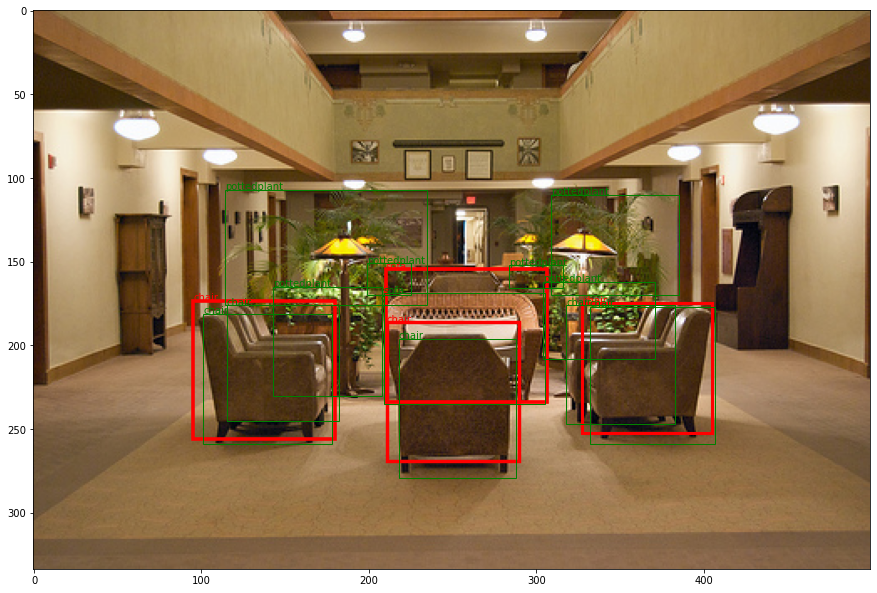

In [218]:
import random
utils.mc_dropout.set_training_mode_for_dropout(model, False)
# i = random.randint(0, len(data_test))
i=2545
preds = list(map(lambda box: [i] + box, filter(lambda box: box[1]>.5, bbox_dict_to_tensor(model(data_test[i][0].unsqueeze(0).to(device))[0]))))
gt = list(filter(lambda box: box[0]==i, true_boxes))
plot_image(data_test[i][0], TP, gt)

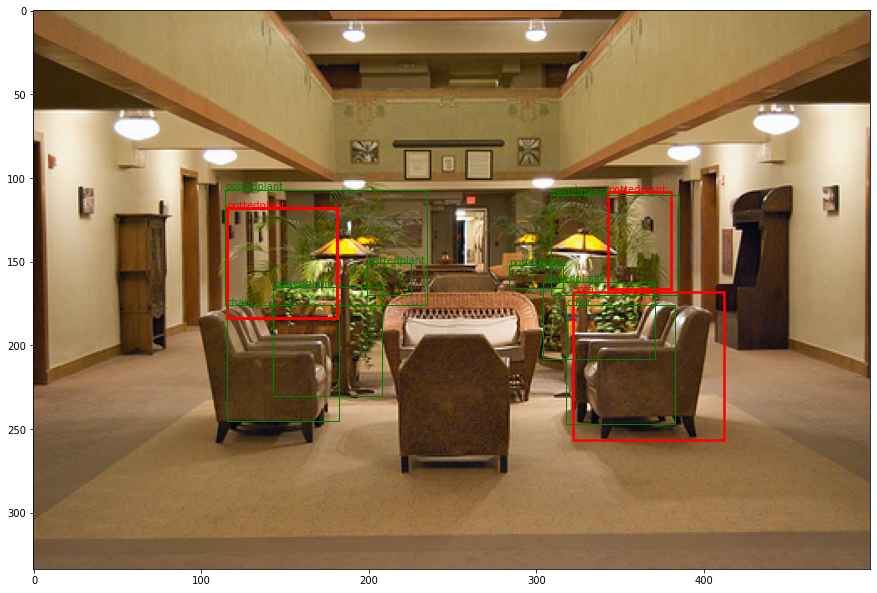

In [219]:
plot_image(data_test[i][0], FP, FN)

In [216]:
len(preds) + len(gt), len(TP)*2 + len(FP) + len(FN)

(19, 19)

In [215]:
TP, FP, FN = correct_boxes(preds, gt, len(VOC_CLASSES))


In [210]:
TP, FP, FN

([[2545,
   9.0,
   0.6175712943077087,
   327.35302734375,
   174.7579345703125,
   404.909423828125,
   252.135498046875],
  [2545,
   9.0,
   0.6848331689834595,
   210.79217529296875,
   186.237060546875,
   289.856201171875,
   269.2997131347656],
  [2545,
   9.0,
   0.7197901010513306,
   95.19983673095703,
   173.3977813720703,
   179.72808837890625,
   256.15106201171875],
  [2545,
   18.0,
   0.7309618592262268,
   210.0118865966797,
   154.68365478515625,
   306.17962646484375,
   233.7205352783203]],
 [[2545,
   16.0,
   0.6345823407173157,
   115.14822387695312,
   117.94036865234375,
   180.72085571289062,
   183.42283630371094],
  [2545,
   16.0,
   0.5253145694732666,
   342.76397705078125,
   108.37118530273438,
   380.36474609375,
   166.1055145263672],
  [2545,
   18.0,
   0.5056842565536499,
   322.1126403808594,
   168.39999389648438,
   411.9198303222656,
   256.8504943847656]],
 [[2545, 9.0, 1.0, 318.0, 176.0, 383.0, 247.0],
  [2545, 9.0, 1.0, 218.0, 196.0, 288.0,

In [159]:
preds, gt

([[2545,
   18.0,
   0.7309618592262268,
   210.0118865966797,
   154.68365478515625,
   306.17962646484375,
   233.7205352783203],
  [2545,
   9.0,
   0.7197901010513306,
   95.19983673095703,
   173.3977813720703,
   179.72808837890625,
   256.15106201171875],
  [2545,
   9.0,
   0.6848331689834595,
   210.79217529296875,
   186.237060546875,
   289.856201171875,
   269.2997131347656],
  [2545,
   16.0,
   0.6345823407173157,
   115.14822387695312,
   117.94036865234375,
   180.72085571289062,
   183.42283630371094],
  [2545,
   9.0,
   0.6175712943077087,
   327.35302734375,
   174.7579345703125,
   404.909423828125,
   252.135498046875],
  [2545,
   16.0,
   0.5253145694732666,
   342.76397705078125,
   108.37118530273438,
   380.36474609375,
   166.1055145263672],
  [2545,
   18.0,
   0.5056842565536499,
   322.1126403808594,
   168.39999389648438,
   411.9198303222656,
   256.8504943847656]],
 [[2545, 9.0, 1.0, 332.0, 177.0, 407.0, 259.0],
  [2545, 9.0, 1.0, 318.0, 176.0, 383.0, 

In [157]:


correct_boxes(preds, gt, len(VOC_CLASSES))

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [116]:
pred_boxes[-1][0]

5822

In [123]:
a=[1,2,3,4,5,6]
for i in range(len(a)):
    print(a)
    a.pop(0)
a

[1, 2, 3, 4, 5, 6]
[2, 3, 4, 5, 6]
[3, 4, 5, 6]
[4, 5, 6]
[5, 6]
[6]


[]

In [21]:
pred_boxes

[[0,
  20.0,
  0.985025942325592,
  62.33821105957031,
  11.087247848510742,
  493.0638122558594,
  267.9551696777344],
 [1,
  19.0,
  0.9794479012489319,
  30.064210891723633,
  57.785675048828125,
  488.772216796875,
  324.7522888183594],
 [3,
  10.0,
  0.7361497282981873,
  224.23373413085938,
  159.6692352294922,
  300.26593017578125,
  223.7890625],
 [3,
  13.0,
  0.5330555438995361,
  467.7466125488281,
  166.10267639160156,
  500.0,
  215.4369659423828],
 [4,
  20.0,
  0.9021589756011963,
  76.3587875366211,
  32.38308334350586,
  401.2837829589844,
  307.9095458984375],
 [4, 20.0, 0.506807804107666, 0.0, 0.0, 267.6877746582031, 285.26068115234375],
 [5, 1.0, 0.9954137206077576, 0.0, 151.27232360839844, 500.0, 284.5048828125],
 [6,
  15.0,
  0.968841016292572,
  127.86530303955078,
  11.97488784790039,
  348.95745849609375,
  365.05328369140625],
 [7,
  7.0,
  0.98003089427948,
  34.24770736694336,
  58.22441482543945,
  487.4207458496094,
  375.0],
 [7,
  7.0,
  0.6330721974372

NameError: name 'labels' is not defined

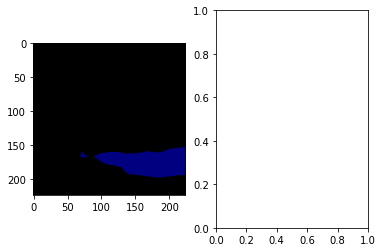

In [9]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(decode_segmap(progress.predictions[2]))
axs[1].imshow(decode_segmap(labels[2]))

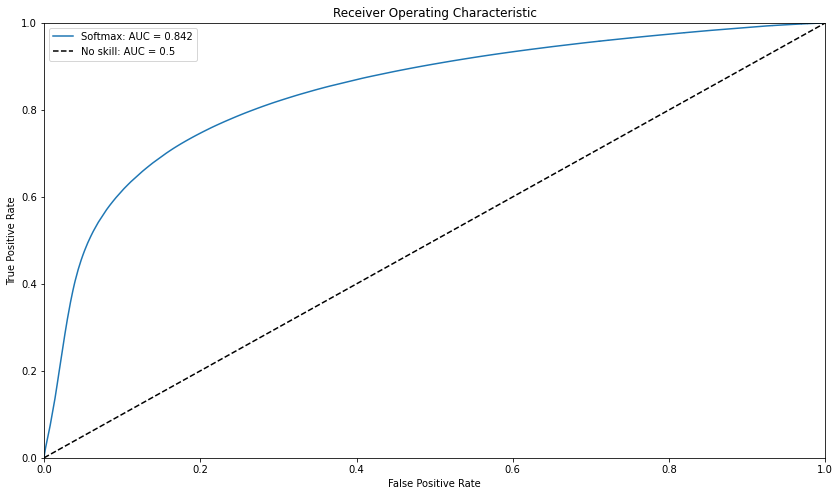

In [12]:
curves = []

correct = progress.predictions.ravel() == progress.labels.ravel()
fpr, tpr, _ = metrics.roc_curve(correct, progress.max_probs)
roc_auc = metrics.auc(fpr, tpr)

prec, recall, _ = metrics.precision_recall_curve(correct, progress.max_probs)
aupr = metrics.auc(recall, prec)
curves.append({
    "fpr": fpr,
    "tpr": tpr,
    "auroc": roc_auc,
    "prec": prec,
    "recall": recall,
    "aupr": aupr,
    "label": "Softmax"
})

# correct = progress.dropout_predictions == progress.labels
# dropout_max_probs = progress.dropout_outputs.max(axis=-1)
# fpr, tpr, _ = metrics.roc_curve(correct, dropout_max_probs)
# roc_auc = metrics.auc(fpr, tpr)

# prec, recall, _ = metrics.precision_recall_curve(correct, dropout_max_probs)
# aupr = metrics.auc(recall, prec)

# curves.append({
#     "fpr": fpr,
#     "tpr": tpr,
#     "auroc": roc_auc,
#     "prec": prec,
#     "recall": recall,
#     "aupr": aupr,
#     "label": "MC Dropout"
# })


plt.figure(figsize=(14, 8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"],
             label=f"{curve['label']}: AUC = {curve['auroc']:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

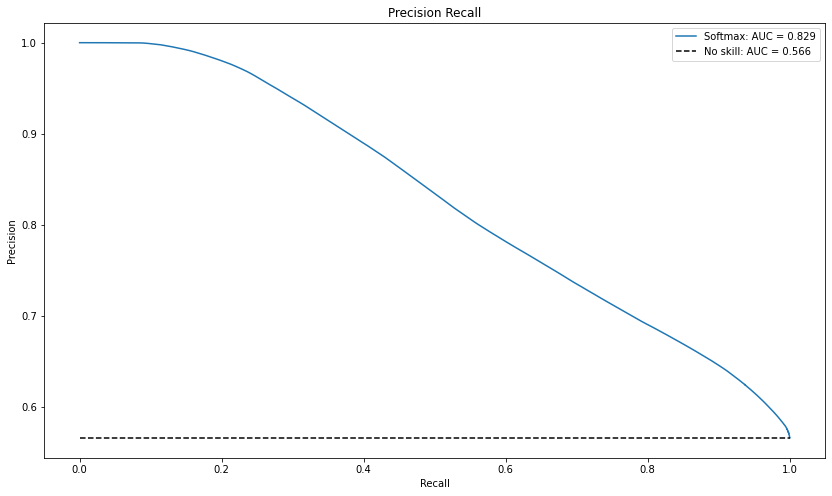

In [10]:
no_skill = correct.sum() / len(correct)
plt.figure(figsize=(14, 8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"],
             label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels
plt.plot([0, 1], [no_skill, no_skill], color="k",
         linestyle='--', label=f'No skill: AUC = {no_skill:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()